# FUNCTIONS

In [1]:
def get_model_size(model):
    total_params = sum(p.numel() for p in model.parameters())
    total_size = sum(p.element_size() * p.numel() for p in model.parameters())
    # SIZE in GB
    print(f"TOTAL PARAMS : {total_params}")
    print(f"MODEL SIZE : {total_size/(1024**3)} GB")

    
def evaluate_model(model, loader, criterion):
    
    model.eval()
    total_loss=0
    with torch.no_grad():
        for batch in loader:

            # Your training code here
            batch = batch[0].to(device)  # Move data to the device if using GPU
            outputs = model(batch)

            recon_loss = criterion(outputs, batch).item()*len(batch)
#             regularization_loss = model.calculate_regularization_loss()
#             loss = recon_loss + regularization_loss

            #train_loss_liss.append(round(loss.item(),6))
            total_loss += round(recon_loss,6)
        
    total_loss = total_loss/len(loader.dataset)

    model.train()
    return total_loss

# IMPORTS

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset

# !nvidia-smi
import argparse, os
import numpy as np



/home/aditya/anaconda3/envs/ldm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# python ridge.py --target c --roi ventral --subject subj01
# python ridge.py --target init_latent --roi early --subject subj01

# SETUP

In [4]:
target = 'init_latent'
roi = 'early'
subject = 'subj01'
# backend = set_backend("numpy", on_error="warn")

mridir = f'../../mrifeat/{subject}/'
featdir = '../../nsdfeat/subjfeat/'
savedir = f'../..//decoded_net/{subject}/'
os.makedirs(savedir, exist_ok=True)

In [5]:
X = []
X_te = []

for croi in [roi]:
    if 'conv' in target: # We use averaged features for GAN due to large number of dimension of features
        cX = np.load(f'{mridir}/{subject}_{croi}_betas_ave_tr.npy').astype("float32")
    else:
        cX = np.load(f'{mridir}/{subject}_{croi}_betas_tr.npy').astype("float32")
    
    cX_te = np.load(f'{mridir}/{subject}_{croi}_betas_ave_te.npy').astype("float32")
    
    X.append(cX)
    X_te.append(cX_te)

X = np.hstack(X)
X_te = np.hstack(X_te)


Y = np.load(f'{featdir}/{subject}_each_{target}_tr.npy').astype("float32").reshape([24980,-1])
Y_te = np.load(f'{featdir}/{subject}_ave_{target}_te.npy').astype("float32").reshape([X_te.shape[0],-1])

In [6]:
print(f'Now making decoding model for... {subject}:  {roi}, {target}')
print(f'X {X.shape}, Y {Y.shape}, X_te {X_te.shape}, Y_te {Y_te.shape}')

Now making decoding model for... subj01:  early, init_latent
X (24980, 5917), Y (24980, 6400), X_te (982, 5917), Y_te (982, 6400)


______
_____

## Subset small data : For Experimentation

In [7]:
# num_samples = 500
# X_train = X[:num_samples, :].copy()
# Y_train = Y[:num_samples, :].copy()
# X_test = X_te[:num_samples//5, :].copy()
# Y_test = Y_te[:num_samples//5, :].copy()

_______
_______

# DATA

In [12]:
# from sklearn.preprocessing import StandardScaler

# # Initialize the StandardScaler
# scaler = StandardScaler()

# # Fit the scaler on your data and transform it
# Y_total = scaler.fit_transform(Y)
Y_total = Y

In [13]:
Y_total.shape, Y_total[:,2000].mean(), Y_total[:,2000].std()

((24980, 6400), -0.03880588, 0.98068917)

In [14]:
# Split the data into training and testing sets
Y_train, Y_val = train_test_split(Y_total, test_size=0.2, random_state=42)

In [15]:
# Convert data to PyTorch tensors
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float16)
train_dataset = TensorDataset(Y_train_tensor)

Y_val_tensor = torch.tensor(Y_val, dtype=torch.float16)
val_dataset = TensorDataset(Y_val_tensor)

# Create a DataLoader
batch_size = 64  # Adjust as needed
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size , shuffle=False)


In [16]:
Y_train.shape, Y_val.shape

((19984, 6400), (4996, 6400))

In [17]:
del Y_train
del Y_val

# MODEL

In [18]:
# Define a more complex autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_size, encoding_size, weight_decay=1e-4):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 2500),
            nn.ReLU(),
            nn.Linear(2500, encoding_size)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_size, 2500),
            nn.ReLU(),
            nn.Linear(2500, input_size)
        )
        
        # Add L2 regularization to the linear layers
        self.regularization = nn.MSELoss(reduction='sum')
        self.weight_decay = weight_decay

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def calculate_regularization_loss(self):
        reg_loss = 0
        for param in self.parameters():
            reg_loss += self.regularization(param, torch.zeros_like(param))
        return self.weight_decay * reg_loss
        #return 0.0


In [19]:
# Set the input and encoding dimensions
input_size = Y_train_tensor.shape[1]  # 59136
encoding_size = 1000  # Adjust the encoding size as needed
#encoding_size = 512  # Adjust the encoding size as needed


# Create the autoencoder model
model = Autoencoder(input_size, encoding_size)
model = model.half()

In [20]:
get_model_size(model)

TOTAL PARAMS : 37012400
MODEL SIZE : 0.06894096732139587 GB


In [21]:
# torch.cuda.empty_cache()
# !nvidia-smi

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=6400, out_features=2500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2500, out_features=1000, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1000, out_features=2500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2500, out_features=6400, bias=True)
  )
  (regularization): MSELoss()
)

In [23]:
# torch.cuda.empty_cache()
# !nvidia-smi

In [24]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

# TRAINING

In [25]:
num_epochs = 500
train_loss_liss = []
val_loss_liss = []
best_loss = float('inf')
PATIENCE = 3
loss_per=100

for epoch in range(num_epochs):

    for batch_idx, batch in enumerate(train_data_loader):
    
        # Your training code here
        batch = batch[0].to(device)  # Move data to the device if using GPU
        optimizer.zero_grad()
        outputs = model(batch)
        
        # TOTAL LOSS
        recon_loss = criterion(outputs, batch)
        regularization_loss = model.calculate_regularization_loss()
        loss = recon_loss + regularization_loss
        
        loss.backward()
        optimizer.step()
        

    # AT THE END OF EPOCH
    val_loss = evaluate_model(model=model, loader=val_data_loader, criterion=criterion)
    train_loss = evaluate_model(model=model, loader=train_data_loader, criterion=criterion)
    
    if epoch>0:
        loss_per = ((old_loss-val_loss)/old_loss)*100
    
    if val_loss < best_loss:
        
        # SAVE BEST PARAMETERS
        best_params = model.state_dict()
        best_loss = val_loss
        patience_counter=0
        
    else:
        
        patience_counter +=1
        
    
    
    
    old_loss = val_loss
    
    
    val_loss_liss.append(val_loss)
    train_loss_liss.append(train_loss)
    
    print(f"EPOCH {epoch+1} COMPLETED | TRAIN LOSS :: {train_loss}| VAL LOSS :: {val_loss}")
    
    if patience_counter >= PATIENCE: # or loss_per<.01:
        print(f"\n\n BREAKING AT EPOCH {epoch+1}")
        break

EPOCH 1 COMPLETED | TRAIN LOSS :: 0.4983662711168935| VAL LOSS :: 0.49868684007205766
EPOCH 2 COMPLETED | TRAIN LOSS :: 0.4541691947057646| VAL LOSS :: 0.4548097461969576
EPOCH 3 COMPLETED | TRAIN LOSS :: 0.43658442378903123| VAL LOSS :: 0.4374306084867894
EPOCH 4 COMPLETED | TRAIN LOSS :: 0.42340258927141716| VAL LOSS :: 0.42447571337069656
EPOCH 5 COMPLETED | TRAIN LOSS :: 0.414605512510008| VAL LOSS :: 0.4158615954763811
EPOCH 6 COMPLETED | TRAIN LOSS :: 0.4087058709467574| VAL LOSS :: 0.4100735666533227
EPOCH 7 COMPLETED | TRAIN LOSS :: 0.4039407307345877| VAL LOSS :: 0.4054943172538031
EPOCH 8 COMPLETED | TRAIN LOSS :: 0.4000860845176141| VAL LOSS :: 0.4017778676941553
EPOCH 9 COMPLETED | TRAIN LOSS :: 0.3967038865592474| VAL LOSS :: 0.398525460968775
EPOCH 10 COMPLETED | TRAIN LOSS :: 0.39351735293234585| VAL LOSS :: 0.39545757706164936
EPOCH 11 COMPLETED | TRAIN LOSS :: 0.39093247252802243| VAL LOSS :: 0.39300053322658124
EPOCH 12 COMPLETED | TRAIN LOSS :: 0.38878075115092076| V

EPOCH 96 COMPLETED | TRAIN LOSS :: 0.34733177166733387| VAL LOSS :: 0.36062482806244994
EPOCH 97 COMPLETED | TRAIN LOSS :: 0.34716972798238593| VAL LOSS :: 0.36055348178542834
EPOCH 98 COMPLETED | TRAIN LOSS :: 0.3469357517514011| VAL LOSS :: 0.3603453074459568
EPOCH 99 COMPLETED | TRAIN LOSS :: 0.3468765246697358| VAL LOSS :: 0.3604641525220176
EPOCH 100 COMPLETED | TRAIN LOSS :: 0.34653464956965574| VAL LOSS :: 0.36021453883106486
EPOCH 101 COMPLETED | TRAIN LOSS :: 0.3465061111389111| VAL LOSS :: 0.3601549207365893
EPOCH 102 COMPLETED | TRAIN LOSS :: 0.34626451160928745| VAL LOSS :: 0.36013596036829465
EPOCH 103 COMPLETED | TRAIN LOSS :: 0.34616951371096877| VAL LOSS :: 0.3600777105684548
EPOCH 104 COMPLETED | TRAIN LOSS :: 0.345957039081265| VAL LOSS :: 0.3598640630504404
EPOCH 105 COMPLETED | TRAIN LOSS :: 0.3458767013610889| VAL LOSS :: 0.359904329663731
EPOCH 106 COMPLETED | TRAIN LOSS :: 0.3456960881204964| VAL LOSS :: 0.35972039351481183
EPOCH 107 COMPLETED | TRAIN LOSS :: 0.3

KeyboardInterrupt: 

# PLOT LOSSES 

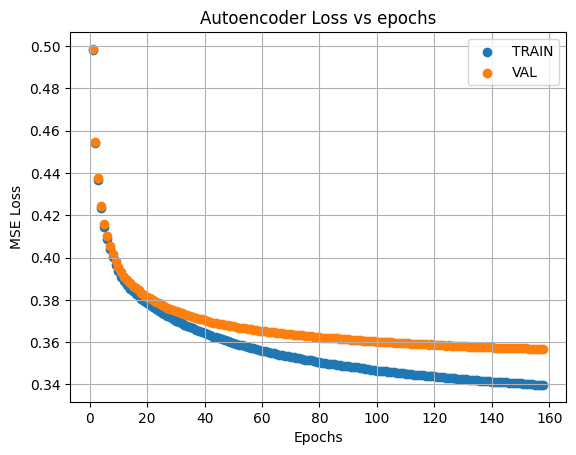

In [26]:
import matplotlib.pyplot as plt

# Assuming you have a list of x and y values
x_values = np.array(range(len(train_loss_liss))) + 1
y_values = np.array(train_loss_liss)


# Create a scatter plot
plt.scatter(x_values, y_values, label = 'TRAIN')
plt.scatter(x_values, np.array(val_loss_liss), label = 'VAL')

plt.grid()
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Autoencoder Loss vs epochs')
plt.legend()

plt.show()

# SAVE MODEL

In [27]:
# Save the entire model (including parameters, architecture, and optimizer state)
torch.save(model, 'autoencoder_init_latent_early.pth')
#torch.save(best_params, 'autoencoder_trained_params_init_latent_early.pth')

# LOAD MODEL

In [28]:
# Load the entire model
model_init_latent_early = torch.load('autoencoder_init_latent_early.pth')


In [29]:
model_init_latent_early

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=6400, out_features=2500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2500, out_features=1000, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1000, out_features=2500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2500, out_features=6400, bias=True)
  )
  (regularization): MSELoss()
)